# TFLite Training
https://github.com/liuyy3364/AAML_MCU_TinyML_Lab/blob/master/utils/train.py

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from keras.datasets import cifar10
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

In [ ]:
#learning rate schedule
def lr_schedule(epoch):
  initial_learning_rate = 0.001
  decay_per_epoch = 0.99
  lrate = initial_learning_rate * (decay_per_epoch ** epoch)
  print('Learning rate = %f'%lrate)
  return lrate

lr_scheduler = LearningRateScheduler(lr_schedule)

#optimizer
optimizer = tf.keras.optimizers.Adam()

#define data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

## load cifar10 data

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train , 10)
y_test = to_categorical(y_test , 10)

170498071/170498071 [==============================] - 3s 0us/step


## show cifar 10 images

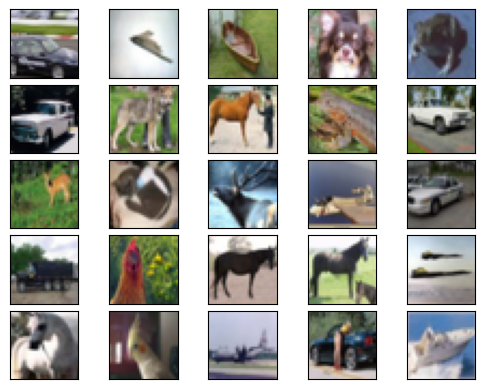

In [ ]:
num_plot = 5
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
  for n in range(num_plot):
    idx = np.random.randint(0, x_train.shape[0])
    ax[m, n].imshow(x_train[idx])
    ax[m, n].get_xaxis().set_visible(False)
    ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()


## define model & training
https://github.com/mlcommons/tiny/blob/master/benchmark/training/image_classification/keras_model.py

In [ ]:
def resnet_v1_eembc():
    # Resnet parameters
    input_shape=[32,32,3] # default size for cifar10
    num_classes=10 # default class number for cifar10
    num_filters = 16 # this should be 64 for an official resnet model

    # Input layer, change kernel size to 7x7 and strides to 2 for an official resnet
    inputs = Input(shape=input_shape)
    x = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x) # uncomment this for official resnet model


    # First stack

    # Weight layers
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(y)
    y = BatchNormalization()(y)

    # Overall residual, connect weight layer and identity paths
    x = tf.keras.layers.add([x, y])
    x = Activation('relu')(x)


    # Second stack

    # Weight layers
    num_filters = 32 # Filters need to be double for each stack
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(y)
    y = BatchNormalization()(y)

    # Adjust for change in dimension due to stride in identity
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)

    # Overall residual, connect weight layer and identity paths
    x = tf.keras.layers.add([x, y])
    x = Activation('relu')(x)


    # Third stack

    # Weight layers
    num_filters = 64
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(y)
    y = BatchNormalization()(y)

    # Adjust for change in dimension due to stride in identity
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)

    # Overall residual, connect weight layer and identity paths
    x = tf.keras.layers.add([x, y])
    x = Activation('relu')(x)

    # Final classification layer.
    pool_size = int(np.amin(x.shape[1:3]))
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
batch_size = 64
epochs = 5
save_model_name = "resnet_v1_eembc"

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 16)           448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 16)           64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 16)           0         ['batch_normalization[0][0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


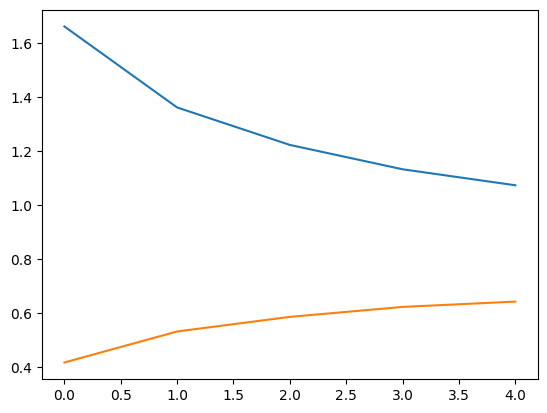

In [ ]:
model = resnet_v1_eembc()
model.summary()

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)


model.compile(
    optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy', loss_weights=None,
    weighted_metrics=None, run_eagerly=None )

# fits the model on batches with real-time data augmentation:
History = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size,
         subset='training'),
         validation_data=datagen.flow(x_train, y_train,
         batch_size=batch_size, subset='validation'),
         steps_per_epoch=len(x_train) * 0.8 / batch_size, epochs=epochs)

plt.plot(np.array(range(epochs)), History.history['loss'])
plt.plot(np.array(range(epochs)), History.history['accuracy'])
plt.savefig('train_loss_acc.png')
# model_name = "trainedResnet.h5"
model.save(f"trained_models/{save_model_name}.h5")

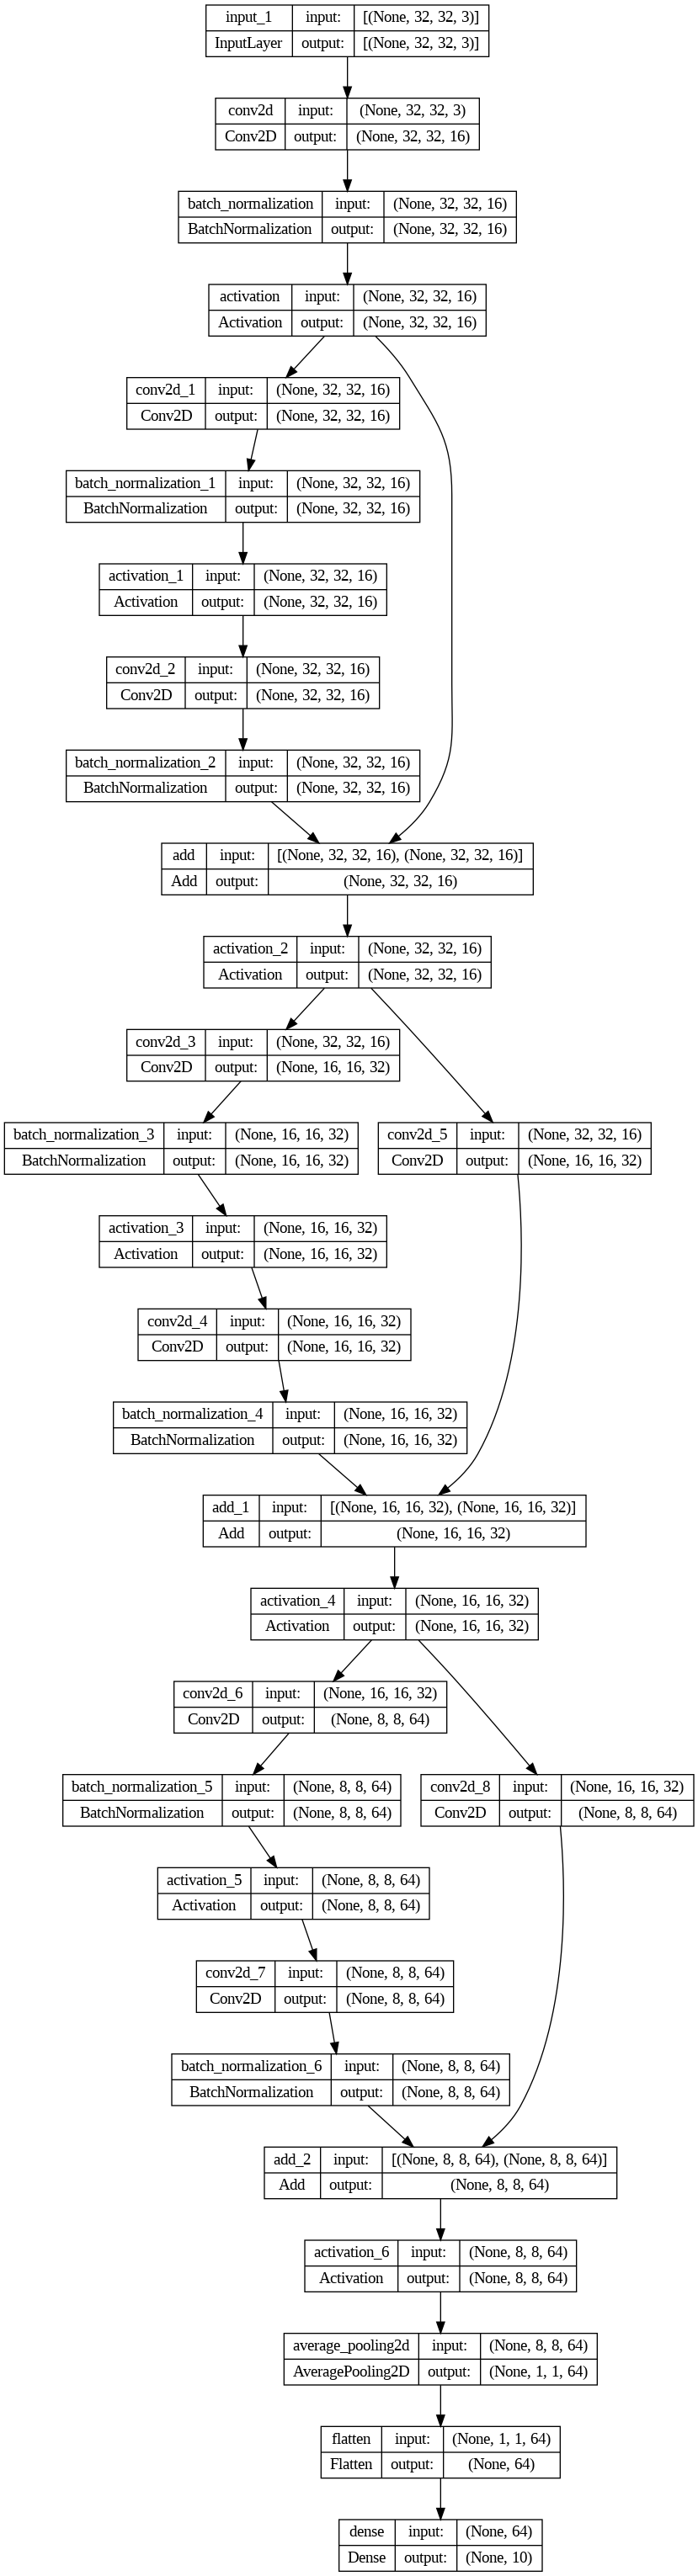

In [ ]:
tf.keras.utils.plot_model(model , show_shapes=True , to_file=f"{save_model_name}.png")

## export model to tflite


In [ ]:
keras_model = tf.keras.models.load_model(f'/content/trained_models/{save_model_name}.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()
open(f'{save_model_name}.tflite', 'wb').write(tflite_model)

318332

## export with quantization int8

In [ ]:
def representative_dataset_generator():
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  for i in range(1000):
    sample_img = np.expand_dims(np.array(x_train[i], dtype=np.float32), axis=0)
    yield [sample_img]

keras_model = tf.keras.models.load_model(f'/content/trained_models/{save_model_name}.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = representative_dataset_generator
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model = converter.convert()
open(f'{save_model_name}_quant.tflite', 'wb').write(tflite_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


95408

In [ ]:
del x_train , y_train , x_test, y_test

# TFLM
https://github.com/liuyy3364/AAML_MCU_TinyML_Lab

## change python version to 3.7

In [ ]:
!sudo apt-get install python3.7
!sudo apt-get update -y
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --config python3 << '2'
!sudo apt install python3-pip
!sudo apt-get install python3.7-distutils
!python -m pip install --upgrade --force-reinstall pip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support
  python3.7-minimal
Suggested packages:
  python3.7-venv binfmt-support
The following NEW packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support python3.7
  python3.7-minimal
0 upgraded, 6 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,698 kB of archives.
After this operation, 17.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 mailcap all 3.70+nmu1ubuntu1 [23.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 mime-support all 3.66 [3,696 B]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 libpython3.7-minimal amd64 3.7.17-1+jammy1 [608 kB]
Get:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 python3.7-minima

In [ ]:
!python -V
!pip -V

Python 3.7.17
pip 23.2.1 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)


## install mbed requirements

In [ ]:
!sudo apt install git mercurial libusb-1.0-0-dev
!pip install mbed-cli
# install python dependency

!wget https://raw.githubusercontent.com/ARMmbed/mbed-os/master/requirements.txt
!sed -i 's/psutil==5.6.7/ /' requirements.txt
!pip install -r requirements.txt


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
The following additional packages will be installed:
  libusb-1.0-doc mercurial-common
Suggested packages:
  kdiff3 | kdiff3-qt | kompare | meld | tkcvs | mgdiff qct python3-mysqldb
  python3-openssl python3-pygments
The following NEW packages will be installed:
  libusb-1.0-0-dev libusb-1.0-doc mercurial mercurial-common
0 upgraded, 4 newly installed, 0 to remove and 16 not upgraded.
Need to get 3,485 kB of archives.
After this operation, 17.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libusb-1.0-0-dev amd64 2:1.0.25-1ubuntu2 [76.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libusb-1.0-doc all 2:1.0.25-1ubuntu2 [183 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 mercurial-common all 6.1.1-1ubuntu1 [2,906 kB]
Get:4 http://archive.u

--2023-09-09 10:52:48--  https://raw.githubusercontent.com/ARMmbed/mbed-os/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 591 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     591  --.-KB/s    in 0s      

2023-09-09 10:52:49 (41.0 MB/s) - ‘requirements.txt’ saved [591/591]

Ignoring hidapi: markers 'platform_system != "Linux"' don't match your environment
Ignoring pywin32: markers 'platform_system == "Windows"' don't match your environment
Ignoring wmi: markers 'platform_system == "Windows"' don't match your environment
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for PyYAML>=5.4 from https://files.pythonhosted.org/packages/d7/8f/db62b0df635b9008fe90aa68424e

In [ ]:
!wget -O gcc-arm-none-eabi-10.3-2021.10-x86_64-linux.tar.bz2 https://developer.arm.com/-/media/Files/downloads/gnu-rm/10.3-2021.10/gcc-arm-none-eabi-10.3-2021.10-x86_64-linux.tar.bz2?rev=78196d3461ba4c9089a67b5f33edf82a&hash=D484B37FF37D6FC3597EBE2877FB666A41D5253B
!sudo tar -jxvf ./gcc-arm-none-eabi-10.3-2021.10-x86_64-linux.tar.bz2 -C /usr/local/

串流輸出內容已截斷至最後 5000 行。
gcc-arm-none-eabi-10.3-2021.10/arm-none-eabi/include/c++/10.3.1/arm-none-eabi/thumb/v8-m.main+fp/hard/bits/c++config.h
gcc-arm-none-eabi-10.3-2021.10/arm-none-eabi/include/c++/10.3.1/arm-none-eabi/thumb/v7-r+fp.sp/
gcc-arm-none-eabi-10.3-2021.10/arm-none-eabi/include/c++/10.3.1/arm-none-eabi/thumb/v7-r+fp.sp/softfp/
gcc-arm-none-eabi-10.3-2021.10/arm-none-eabi/include/c++/10.3.1/arm-none-eabi/thumb/v7-r+fp.sp/softfp/ext/
gcc-arm-none-eabi-10.3-2021.10/arm-none-eabi/include/c++/10.3.1/arm-none-eabi/thumb/v7-r+fp.sp/softfp/ext/opt_random.h
gcc-arm-none-eabi-10.3-2021.10/arm-none-eabi/include/c++/10.3.1/arm-none-eabi/thumb/v7-r+fp.sp/softfp/bits/
gcc-arm-none-eabi-10.3-2021.10/arm-none-eabi/include/c++/10.3.1/arm-none-eabi/thumb/v7-r+fp.sp/softfp/bits/c++locale.h
gcc-arm-none-eabi-10.3-2021.10/arm-none-eabi/include/c++/10.3.1/arm-none-eabi/thumb/v7-r+fp.sp/softfp/bits/os_defines.h
gcc-arm-none-eabi-10.3-2021.10/arm-none-eabi/include/c++/10.3.1/arm-none-eabi/thumb/v7-r

In [ ]:
!pip install psutil
!pip install Jinja2
!pip install jsonschema

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.1/282.1 kB 3.3 MB/s eta 0:00:00


## mbed setting

In [ ]:
!mbed config -G GCC_ARM_PATH /usr/local/gcc-arm-none-eabi-10.3-2021.10/bin/
!mbed config -G TOOLCHAIN GCC_ARM

[mbed] /usr/local/gcc-arm-none-eabi-10.3-2021.10/bin/ now set as global GCC_ARM_PATH
[mbed] GCC_ARM now set as global TOOLCHAIN


In [ ]:
!git clone --recurse-submodules https://github.com/liuyy3364/AAML_MCU_TinyML_Lab.git

Cloning into 'AAML_MCU_TinyML_Lab'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 37 (delta 2), reused 3 (delta 1), pack-reused 29
Receiving objects: 100% (37/37), 163.47 MiB | 29.23 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (33/33), done.
Submodule 'AAML_TFLM_basic' (https://github.com/liuyy3364/AAML_TFLM_basic.git) registered for path 'AAML_TFLM_basic'
Submodule 'AAML_TFLM_cmsis' (https://github.com/liuyy3364/AAML_TFLM_cmsis.git) registered for path 'AAML_TFLM_cmsis'
Submodule 'tiny' (https://github.com/mlcommons/tiny.git) registered for path 'tiny'
Cloning into '/content/AAML_MCU_TinyML_Lab/AAML_TFLM_basic'...
remote: Enumerating objects: 499, done.        
remote: Counting objects: 100% (499/499), done.        
remote: Compressing objects: 100% (289/289), done.        
remote: Total 499 (delta 200), reused 488 (delta 192), pack-reused 0        
Receiving o

In [ ]:
%cd AAML_MCU_TinyML_Lab

/content/AAML_MCU_TinyML_Lab


## export tflite model to tflm model

In [ ]:
!xxd -i /content/{save_model_name}.tflite > model.cc
!(echo -ne "#include \"ic/ic_model_data.h\"\nalignas(8) "; cat model.cc) > ic_model_data.cc
!sed -i -E 's/(unsigned\s.*\s).*(_len|\[\])/const \1model\2/g' ic_model_data.cc
!cp ic_model_data.cc AAML_TFLM_basic/ic/

In [ ]:
!xxd -i /content/{save_model_name}_quant.tflite > model.cc
!(echo -ne "#include \"ic/ic_model_data.h\"\nalignas(8) "; cat model.cc) > ic_model_data.cc
!sed -i -E 's/(unsigned\s.*\s).*(_len|\[\])/const \1model\2/g' ic_model_data.cc
!cp ic_model_data.cc AAML_TFLM_cmsis/ic/

#AAML_TFLM_basic

## add library

In [ ]:
%cd AAML_TFLM_basic

/content/AAML_MCU_TinyML_Lab/AAML_TFLM_basic


In [ ]:
!mbed add mbed-os
!mbed deploy

[mbed] Working path "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_basic" (library)
[mbed] Program path "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_basic"
[mbed] WARNING: Program "AAML_TFLM_basic" in "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_basic" does not use source control management.
       To fix this you should use "mbed new ." in the root of your program.
---
[mbed] Adding library "mbed-os" from "https://github.com/ARMmbed/mbed-os" at latest revision in the current branch
[mbed] Updating reference "mbed-os" -> "https://github.com/ARMmbed/mbed-os/#67c25e8365a0a75846c5886d2040fc685f2312b5"
[mbed] Working path "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_basic" (library)
[mbed] Program path "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_basic"
[mbed] WARNING: Program "AAML_TFLM_basic" in "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_basic" does not use source control management.
       To fix this you should use "mbed new ." in the root of your program.
---
[mbed] Updating library "mbed-os" to rev #67c25e8365a0


## compile to bin file
https://github.com/liuyy3364/AAML_TFLM_basic/tree/58233998843796f42e8adc1b586f5c7a7f429ba0

In [ ]:
!sudo mbed compile

[mbed] Working path "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_basic" (library)
[mbed] Program path "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_basic"
[Warning] @,: Compiler version mismatch: Have 10.3.1; expected version >= 9.0.0 and < 10.0.0
Building project AAML_TFLM_basic (NUCLEO_F767ZI, GCC_ARM)
Scan: AAML_TFLM_basic
Compile [  0.3%]: ic_inputs.cc
Compile [  0.5%]: internally_implemented.cpp
Compile [  0.8%]: ic_model_settings.cc
Compile [  1.1%]: main.cpp
Compile [  1.3%]: mbed_tz_context.c
Compile [  1.6%]: AnalogIn.cpp
Compile [  1.8%]: ic_model_data.cc
Compile [  2.1%]: AnalogOut.cpp
Compile [  2.4%]: BufferedSerial.cpp
Compile [  2.6%]: BusIn.cpp
Compile [  2.9%]: BusInOut.cpp
Compile [  3.2%]: BusOut.cpp
Compile [  3.4%]: DigitalIn.cpp
Compile [  3.7%]: CAN.cpp
Compile [  4.0%]: DigitalInOut.cpp
Compile [  4.2%]: DigitalOut.cpp
Compile [  4.5%]: FlashIAP.cpp
Compile [  4.7%]: I2CSlave.cpp
Compile [  5.0%]: I2C.cpp
Compile [  5.3%]: InterruptIn.cpp
Compile [  5.5%]: MbedCRC.cpp
Comp

In [ ]:
from google.colab import files
files.download('./BUILD/NUCLEO_F767ZI/GCC_ARM/AAML_TFLM_basic.bin')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# AAML_TFLM_cmsis

In [ ]:
%cd ../AAML_TFLM_cmsis

/content/AAML_MCU_TinyML_Lab/AAML_TFLM_cmsis


In [ ]:
!mbed add mbed-os
!mbed deploy

[mbed] Working path "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_cmsis" (library)
[mbed] Program path "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_cmsis"
[mbed] WARNING: Program "AAML_TFLM_cmsis" in "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_cmsis" does not use source control management.
       To fix this you should use "mbed new ." in the root of your program.
---
[mbed] Adding library "mbed-os" from "https://github.com/ARMmbed/mbed-os" at latest revision in the current branch
[mbed] Updating reference "mbed-os" -> "https://github.com/ARMmbed/mbed-os/#67c25e8365a0a75846c5886d2040fc685f2312b5"
[mbed] Working path "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_cmsis" (library)
[mbed] Program path "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_cmsis"
[mbed] WARNING: Program "AAML_TFLM_cmsis" in "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_cmsis" does not use source control management.
       To fix this you should use "mbed new ." in the root of your program.
---
[mbed] Updating library "mbed-os" to rev #67c25e8365a0


In [ ]:
!mbed compile

[mbed] Working path "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_cmsis" (library)
[mbed] Program path "/content/AAML_MCU_TinyML_Lab/AAML_TFLM_cmsis"
[Warning] @,: Compiler version mismatch: Have 10.3.1; expected version >= 9.0.0 and < 10.0.0
Building project AAML_TFLM_cmsis (NUCLEO_F767ZI, GCC_ARM)
Scan: AAML_TFLM_cmsis
Compile [  0.2%]: ic_inputs.cc
Compile [  0.4%]: internally_implemented.cpp
Compile [  0.6%]: ic_model_settings.cc
Compile [  0.9%]: main.cpp
Compile [  1.1%]: mbed_tz_context.c
Compile [  1.3%]: ic_model_data.cc
Compile [  1.5%]: AnalogIn.cpp
Compile [  1.7%]: AnalogOut.cpp
Compile [  1.9%]: BusIn.cpp
Compile [  2.2%]: BufferedSerial.cpp
Compile [  2.4%]: BusInOut.cpp
Compile [  2.6%]: BusOut.cpp
Compile [  2.8%]: DigitalIn.cpp
Compile [  3.0%]: CAN.cpp
Compile [  3.2%]: DigitalInOut.cpp
Compile [  3.5%]: DigitalOut.cpp
Compile [  3.7%]: FlashIAP.cpp
Compile [  3.9%]: I2CSlave.cpp
Compile [  4.1%]: I2C.cpp
Compile [  4.3%]: InterruptIn.cpp
Compile [  4.5%]: MbedCRC.cpp
Comp

In [ ]:
from google.colab import files
files.download('./BUILD/NUCLEO_F767ZI/GCC_ARM/AAML_TFLM_cmsis.bin')